# Explotación de resultados para el paper y el dashboard

Este cuaderno tiene como objetivo **explotar la información generada en la Fase 1**, produciendo las tablas, métricas y visualizaciones necesarias para:

- la sección empírica del paper (apartados 6.1 a 6.5)
- el dashboard interactivo basado en Streamlit
- los análisis destinados a responsables públicos y documentación técnica

Se alinea con los ejes analíticos definidos en la narrativa del proyecto PIVI.

---

## 📁 Estructura del cuaderno

### **Celda A — Carga de datos globales**
Carga en memoria los principales artefactos generados por `01_build_foundations.ipynb`:

- `intermediarios_globales.parquet`  
- `country_profiles.parquet`  
- `relaciones_criticas.parquet`  
- `caminos_significativos.parquet`  
- `dependencias{año}.csv.gz` (consolidado de 9.3M registros)

---

### **Celda B — KPIs y análisis para el paper (Secciones 6.1 6.5)**

Incluye los indicadores clave para entender la vulnerabilidad y estructura de dependencias del sistema comercial global:

- **Estadísticas globales** de dependencia y reparto directa vs indirecta  
- **Ranking de países más vulnerables** como importadores  
- **Ranking de países más importantes** como exportadores  
- **Top hubs intermediarios**, análisis de frecuencia, fuerza y score  
- **Relaciones comerciales críticas**, evaluación de redundancia  
- **Análisis sectorial:**  
  - concentración (HHI)  
  - número de proveedores necesarios para cubrir el 80 por ciento de importaciones  
  - distribución por industria

---

### **Celda C — Visualizaciones base**

Conjunto de gráficos esenciales para análisis, paper y dashboard:

- **Heatmap país–industria** de dependencia media  
- **Matriz país–país** de criticidad  
- **Dispersión frecuencia–fuerza** de intermediarios (tamaño ~ score)  
- **Relación criticidad–caminos alternativos**  

Estas visualizaciones refinan las ya esbozadas en la fase previa y se optimizan para su uso interactivo.

---

### **Celda D — Exportación de tablas y figuras**

Genera los ficheros necesarios para la sección empírica del paper y para análisis externos:

- CSV comprimidos en `paper/ficheros_paper/`:  
  - `dependencies_full`  
  - `weighted_dependencies`  
  - `critical_relations`  
  - `intermediary_roles`  
  - `intermediary_summary`
- Figuras en PNG y SVG con metadatos limpios y nombres estándar  

---

### **Celda E — Preparación de datos para el dashboard**

Genera extractos ligeros en Parquet o DuckDB para acelerar la carga del dashboard:

- perfiles de países  
- hubs globales  
- relaciones críticas  
- matriz país–industria  
- criticidad país–país  

También define las consultas típicas que alimentará el dashboard:

- vulnerabilidad por país  
- hubs globales  
- rutas alternativas  
- matrices de calor  

---

Este cuaderno constituye la base analítica y visual del sistema PIVI, conectando la Fase 1 (cálculo) con la Fase 3 (comunicación y dashboard).



# 🔍 Carga de datos globales (Parquet + consolidado)

En esta sección cargamos:

- `intermediarios_globales.parquet`
- `country_profiles.parquet`
- `relaciones_criticas.parquet`
- `caminos_significativos.parquet`
- el archivo consolidado `dependencias{año}.csv.gz`

También verificamos su integridad:

- número esperado de filas
- columnas esenciales
- consistencia básica entre estructuras

Estos archivos provienen del notebook **01_build_foundations.ipynb**, donde se generaron a partir de los resultados de las 170 industrias.


In [30]:
from pathlib import Path
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Limitar hilos numéricos
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

# Rutas base
base_path = Path.cwd().parent.parent
processed_path = base_path / "data" / "processed" / "dependencias_consolidadas"
paper_path = base_path / "paper" / "ficheros_paper"
dashboard_data_path = base_path / "dashboard" / "data"

for p in [processed_path, paper_path, dashboard_data_path]:
    p.mkdir(parents=True, exist_ok=True)
    print("📁 Ruta:", p, "→ existe:", p.exists())


📁 Ruta: c:\Users\Usuario\Documents\Github\Seguridad Economica\data\processed\dependencias_consolidadas → existe: True
📁 Ruta: c:\Users\Usuario\Documents\Github\Seguridad Economica\paper\ficheros_paper → existe: True
📁 Ruta: c:\Users\Usuario\Documents\Github\Seguridad Economica\dashboard\data → existe: True


In [31]:
# Localizar consolidado dependencias{año}.csv.gz más reciente
csv_candidates = sorted(processed_path.glob("dependencias*.csv.gz"))
if not csv_candidates:
    raise FileNotFoundError("No encuentro dependencias*.csv.gz en dependencias_consolidadas")
csv_path = csv_candidates[-1]
print("🗂 Consolidado detectado:", csv_path.name)

deps = pd.read_csv(csv_path, sep=";")
print("✅ dependencias cargado:", deps.shape)

expected_cols = {
    "industry",
    "dependent_country",
    "supplier_country",
    "dependency_value",
    "direct_dependency",
    "indirect_dependency",
    "trade_value",
    "longitud_optima"
}
missing = expected_cols - set(deps.columns)
if missing:
    raise ValueError(f"Faltan columnas en dependencias: {missing}")

# Carga de Parquet globales
interm_path = processed_path / "intermediarios_globales.parquet"
country_prof_path = processed_path / "country_profiles.parquet"
rel_crit_path = processed_path / "relaciones_criticas.parquet"
cam_sig_path = processed_path / "caminos_significativos.parquet"

intermediarios_globales = pd.read_parquet(interm_path)
country_profiles = pd.read_parquet(country_prof_path)
relaciones_criticas = pd.read_parquet(rel_crit_path)
caminos_significativos = pd.read_parquet(cam_sig_path)

print("✅ intermediarios_globales:", intermediarios_globales.shape)
print("✅ country_profiles:", country_profiles.shape)
print("✅ relaciones_criticas:", relaciones_criticas.shape)
print("✅ caminos_significativos:", caminos_significativos.shape)

# Integramos información básica de año si está disponible
anio_detectado = None
for part in csv_path.stem.split("dependencias"):
    if part and part[0].isdigit():
        try:
            anio_detectado = int(part[:4])
        except ValueError:
            pass

print("📆 Año detectado para el análisis:", anio_detectado)


🗂 Consolidado detectado: dependencias2022_borrar.csv.gz
✅ dependencias cargado: (7198964, 8)
✅ intermediarios_globales: (236, 5)
✅ country_profiles: (236, 6)
✅ relaciones_criticas: (7554, 6)
✅ caminos_significativos: (1066802, 5)
📆 Año detectado para el análisis: 2022


## 📊 6.1 Estadísticas globales de dependencia

En esta celda calculamos:

- Media, mediana y desviación estándar de la dependencia total.
- Promedio ponderado de dependencia directa e indirecta.
- Distribución de la longitud óptima de las cadenas (L=1, L=2, L=3…).
- Reparto porcentual (ponderado por comercio) entre dependencia directa e indirecta.

Estos indicadores ofrecen una visión inicial del grado de vulnerabilidad estructural del sistema comercial global.


In [32]:
# 6.1 Estadísticas globales de dependencia

# Eliminamos posibles nulos
deps_clean = deps.dropna(subset=["dependency_value", "direct_dependency", "indirect_dependency"])

global_stats = {
    "n_registros": len(deps_clean),
    "dep_total_media": deps_clean["dependency_value"].mean(),
    "dep_total_mediana": deps_clean["dependency_value"].median(),
    "dep_total_std": deps_clean["dependency_value"].std(),
    "dep_directa_media": deps_clean["direct_dependency"].mean(),
    "dep_indirecta_media": deps_clean["indirect_dependency"].mean(),
}

# Reparto directa vs indirecta ponderado por valor de comercio
total_dep_direct = (deps_clean["direct_dependency"] * deps_clean["trade_value"]).sum()
total_dep_indir = (deps_clean["indirect_dependency"] * deps_clean["trade_value"]).sum()
total_dep = total_dep_direct + total_dep_indir

share_direct = total_dep_direct / total_dep if total_dep > 0 else np.nan
share_indirect = total_dep_indir / total_dep if total_dep > 0 else np.nan

global_stats["share_direct_weighted"] = share_direct
global_stats["share_indirect_weighted"] = share_indirect

print("🔹 Estadísticas globales de dependencia:")
pd.DataFrame([global_stats]).T


🔹 Estadísticas globales de dependencia:


,0
n_registros,7.198964e+06
dep_total_media,1.051767e-02
dep_total_mediana,0.000000e+00
dep_total_std,5.974978e-02
dep_directa_media,4.608621e-03
dep_indirecta_media,5.909049e-03
share_direct_weighted,6.813630e-01
share_indirect_weighted,3.186370e-01


In [33]:
length_dist = deps_clean["longitud_optima"].value_counts().sort_index()
length_dist_pct = length_dist / length_dist.sum()

print("🔹 Distribución de longitud óptima de caminos:")
display(length_dist.to_frame("n"))
display((length_dist_pct * 100).round(2).to_frame("pct"))


🔹 Distribución de longitud óptima de caminos:


,n
longitud_optima,
2,6682761
3,516203


,pct
longitud_optima,
2,92.83
3,7.17


## 🌍 6.2 Países más vulnerables y más importantes

Usamos `country_profiles` para identificar:

- **Países más vulnerables** como importadores (`vulnerability`)
- **Países más importantes** como exportadores (`importance`)
- Porcentajes de dependencia indirecta (`indirect_share`)
- Grado de diversificación de proveedores (`num_suppliers_effective`)
- Posición en el ranking mundial de intermediarios (`global_rank`)

Esto permite comparar vulnerabilidad estructural, importancia estratégica y exposición indirecta.


In [34]:
# ================================
#  B2) Rankings de países
# ================================

# Comprobamos que las columnas existen
required_cp_cols = [
    "country",
    "vulnerability",
    "importance",
    "indirect_share",
    "num_suppliers_effective",
    "global_rank",
]

missing_cp = [c for c in required_cp_cols if c not in country_profiles.columns]
if missing_cp:
    raise ValueError(f"Faltan columnas en country_profiles: {missing_cp}")

# Ranking de países más vulnerables (importadores)
top_vulnerables = (
    country_profiles
    .sort_values("vulnerability", ascending=False)
    .head(30)
)

# Ranking de países más importantes (exportadores)
top_importantes = (
    country_profiles
    .sort_values("importance", ascending=False)
    .head(30)
)

print("🔹 Top 30 países más vulnerables (como importadores):")
display(
    top_vulnerables[
        ["country", "vulnerability", "indirect_share", "num_suppliers_effective"]
    ]
)

print("\n🔹 Top 30 países más importantes (como exportadores):")
display(
    top_importantes[
        ["country", "importance", "global_rank"]
    ]
)


🔹 Top 30 países más vulnerables (como importadores):


,country,vulnerability,indirect_share,num_suppliers_effective
67,ESH,0.997300,0.000483,1.063058
184,SGS,0.994064,0.001440,2.293284
171,PRK,0.985693,0.005361,1.013007
224,VAT,0.976965,0.010155,1.426924
35,BVT,0.947197,0.004405,2.152818
29,BMU,0.939203,0.018821,1.093814
156,NIU,0.936226,0.009230,2.732674
54,CXR,0.928190,0.010492,1.043555
73,FLK,0.927532,0.015745,1.604634
94,HMD,0.899246,0.028697,1.501968



🔹 Top 30 países más importantes (como exportadores):


,country,importance,global_rank
42,CHN,0.620298,1
29,BMU,0.589929,192
222,USA,0.484282,2
75,FRE,0.418898,126
216,TWN,0.399403,29
229,VUT,0.394520,181
119,LAO,0.390839,136
13,AUS,0.381238,17
190,SOM,0.349503,162
58,DEU,0.345779,3


## 🔗 6.3 Intermediarios críticos del sistema global

Aquí analizamos el DataFrame `intermediarios_globales.parquet` para:

- Identificar los **30 principales hubs globales** según `global_score`.
- Evaluar su rol en el sistema mediante:
  - frecuencia como intermediarios
  - fuerza total canalizada
  - ranking global de centralidad
- Cruzarlo con la información de vulnerabilidad e importancia de `country_profiles`.

Este análisis revela qué países concentran la capacidad de canalizar flujos entre terceros.


In [35]:
# ================================
#  B3) Top hubs intermediarios
# ================================

# Aseguramos columnas en intermediarios_globales
required_inter_cols = ["country", "frequency_total", "strength_total", "global_score", "global_rank"]
missing_inter = [c for c in required_inter_cols if c not in intermediarios_globales.columns]
if missing_inter:
    raise ValueError(f"Faltan columnas en intermediarios_globales: {missing_inter}")

# Top hubs globales por score
top_hubs = (
    intermediarios_globales
    .sort_values("global_score", ascending=False)
    .head(30)
)

print("🔹 Top 30 hubs intermediarios globales:")
display(top_hubs)

# Enriquecemos con country_profiles
hubs_enriched = top_hubs.merge(
    country_profiles[[
        "country",
        "vulnerability",
        "importance",
        "indirect_share",
        "num_suppliers_effective",
        "global_rank"
    ]],
    on="country",
    how="left"
)

print("🔹 Hubs con información de perfiles de país:")
display(hubs_enriched)


🔹 Top 30 hubs intermediarios globales:


,country,frequency_total,strength_total,global_score,global_rank
0,CHN,771565,7834.350414,1.000000,1
1,USA,507611,3906.743300,0.562360,2
2,DEU,490552,2381.383462,0.436695,3
3,FRA,289496,1644.060505,0.275994,4
4,ITA,307203,1382.651499,0.265154,5
5,IND,199401,1464.258523,0.215516,6
6,TUR,225451,1203.277043,0.209034,7
7,GBR,196520,1192.313181,0.193196,8
8,NLD,203558,1088.782938,0.188915,9
9,ESP,186680,1143.301127,0.184341,10


🔹 Hubs con información de perfiles de país:


,country,frequency_total,strength_total,global_score,global_rank_x,vulnerability,importance,indirect_share,num_suppliers_effective,global_rank_y
0,CHN,771565,7834.350414,1.000000,1,0.259839,0.620298,0.322706,12.898858,1
1,USA,507611,3906.743300,0.562360,2,0.278877,0.484282,0.350049,5.954393,2
2,DEU,490552,2381.383462,0.436695,3,0.215724,0.345779,0.420142,8.406524,3
3,FRA,289496,1644.060505,0.275994,4,0.225593,0.223535,0.421433,9.159706,4
4,ITA,307203,1382.651499,0.265154,5,0.221746,0.193393,0.398534,9.800905,5
5,IND,199401,1464.258523,0.215516,6,0.267310,0.201157,0.353363,7.938762,6
6,TUR,225451,1203.277043,0.209034,7,0.252661,0.157494,0.376090,8.330744,7
7,GBR,196520,1192.313181,0.193196,8,0.272050,0.249875,0.428100,7.529515,8
8,NLD,203558,1088.782938,0.188915,9,0.234686,0.228263,0.420128,7.604688,9
9,ESP,186680,1143.301127,0.184341,10,0.240783,0.176978,0.413613,9.313546,10


## ⚠️ 6.4 Relaciones comerciales críticas y redundancia

En esta celda identificamos las **relaciones económicas estructuralmente más frágiles**, usando:

- criticidad (`criticidad`)
- número de alternativas (`caminos_alternativos`)

Calculamos:

- Top 50 pares exportador–importador más críticos
- Frecuencias de redundancia (cuántos caminos alternativos existen)
- Distribuciones de severidad

Esto permite resaltar dependencias bilaterales cuya ruptura sería especialmente dañina.


In [36]:
# ================================
#  B4) Relaciones comerciales críticas
# ================================

required_rel_cols = [
    "exportador",
    "importador",
    "dependencia_total",
    "caminos_alternativos",
    "criticidad"
]

missing_rel = [c for c in required_rel_cols if c not in relaciones_criticas.columns]
if missing_rel:
    raise ValueError(f"Faltan columnas en relaciones_criticas: {missing_rel}")

# Orden de criticidad
rel_crit_sorted = (
    relaciones_criticas
    .sort_values("criticidad", ascending=False)
)

top_crit = rel_crit_sorted.head(50)

print("🔹 Top 50 relaciones comerciales críticas:")
display(top_crit)

# Distribución de redundancia
redund_summary = rel_crit_sorted["caminos_alternativos"].value_counts().sort_index()

print("🔹 Distribución de caminos alternativos en relaciones críticas:")
display(redund_summary.to_frame("n"))
display((redund_summary / redund_summary.sum() * 100).round(2).to_frame("pct"))


🔹 Top 50 relaciones comerciales críticas:


,exportador,importador,dependencia_total,caminos_alternativos,criticidad,industry
0,JPN,ARE,1.000000,0,1.0,154 Manufacturing services on physical inputs
2978,BRA,MHL,0.951825,0,1.0,Fresh fruit
2984,THA,MMR,0.951252,0,1.0,Sugar
2983,DNK,GRL,0.951255,0,1.0,Other fabricated metal products n.e.c.
2982,ZAF,SLE,0.951613,0,1.0,Other cereals
2981,CHN,ECU,0.951613,0,1.0,Other sweeteners
2980,ZAF,GUY,0.951615,0,1.0,Processing of nuclear fuel
2979,IND,BTN,0.951631,0,1.0,Electricity distribution & control apparatus
2977,FRA,UMI,0.951882,0,1.0,Basic chemicals except fertilizers
2969,SUR,SEN,0.952583,0,1.0,Fishing


🔹 Distribución de caminos alternativos en relaciones críticas:


,n
caminos_alternativos,
0,4468
1,2097
2,989


,pct
caminos_alternativos,
0,59.15
1,27.76
2,13.09


## 🏭 6.5 Análisis por industria: concentración y resiliencia

Aquí calculamos:

- HHI (Herfindahl-Hirschman Index) para medir **concentración de proveedores**
- Número de proveedores necesarios para cubrir el **80% de las importaciones**
- Distribución sectorial de concentración

Esto revela qué industrias presentan mayor exposición estructural a shocks externos por concentración excesiva.


In [37]:
# ================================
#  B5) Análisis por industria
# ================================

def compute_hhi_and_coverage(group, trade_col="trade_value"):
    total = group[trade_col].sum()
    if total <= 0:
        return pd.Series({"hhi": np.nan, "n_prov_80": np.nan, "share_80": np.nan})
    
    shares = group[trade_col] / total
    hhi = (shares ** 2).sum()
    
    shares_sorted = shares.sort_values(ascending=False)
    cum_shares = shares_sorted.cumsum()
    n_prov_80 = (cum_shares <= 0.8).sum()
    if n_prov_80 < len(shares_sorted):
        n_prov_80 += 1
    
    share_80 = cum_shares.iloc[n_prov_80 - 1]
    
    return pd.Series({"hhi": hhi, "n_prov_80": n_prov_80, "share_80": share_80})

# HHI por industria y país importador
by_industry_country = (
    deps_clean
    .groupby(["industry", "dependent_country"])
    .apply(compute_hhi_and_coverage)
    .reset_index()
)

# Agregado por industria
industry_concentration = (
    by_industry_country
    .groupby("industry")
    .agg(
        hhi_media=("hhi", "mean"),
        hhi_p95=("hhi", lambda x: np.nanpercentile(x, 95)),
        n_prov_80_medio=("n_prov_80", "mean"),
        share_80_media=("share_80", "mean")
    )
    .reset_index()
    .sort_values("hhi_media", ascending=False)
)

print("🔹 Concentración por industria (HHI):")
display(industry_concentration.head(30))


🔹 Concentración por industria (HHI):


C:\Users\Usuario\AppData\Local\Temp\ipykernel_50512\2940413971.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_hhi_and_coverage)


,industry,hhi_media,hhi_p95,n_prov_80_medio,share_80_media
14,168 Services not allocated,0.927843,1.000000,1.266667,0.978738
65,Gas production and distribution,0.864906,1.000000,1.222222,0.973138
88,Mining of lignite,0.814663,1.000000,1.392523,0.965033
133,Publishing of recorded media,0.752505,1.000000,1.900000,0.948613
57,Fishing,0.739882,1.000000,1.704918,0.948273
138,Raw and refined sugar and sugar crops,0.732999,1.000000,1.690000,0.939375
52,"Electricity production, collection, and distri...",0.718450,1.000000,1.706767,0.942791
125,Prepared vegetables,0.703943,1.000000,1.733333,0.944386
74,Live Swine,0.686532,1.000000,1.773585,0.933975
87,Mining of iron ores,0.681812,1.000000,1.869919,0.936589


## 🔥 Heatmap país-industria de dependencia media

Visualizamos una matriz completa país–industria donde cada celda muestra:

**Dependencia media del país importador respecto a todos sus proveedores en esa industria.**

Permite detectar:

- países especialmente vulnerables en sectores concretos
- industrias con patrones geográficos fuertes
- clusters de riesgo compartido


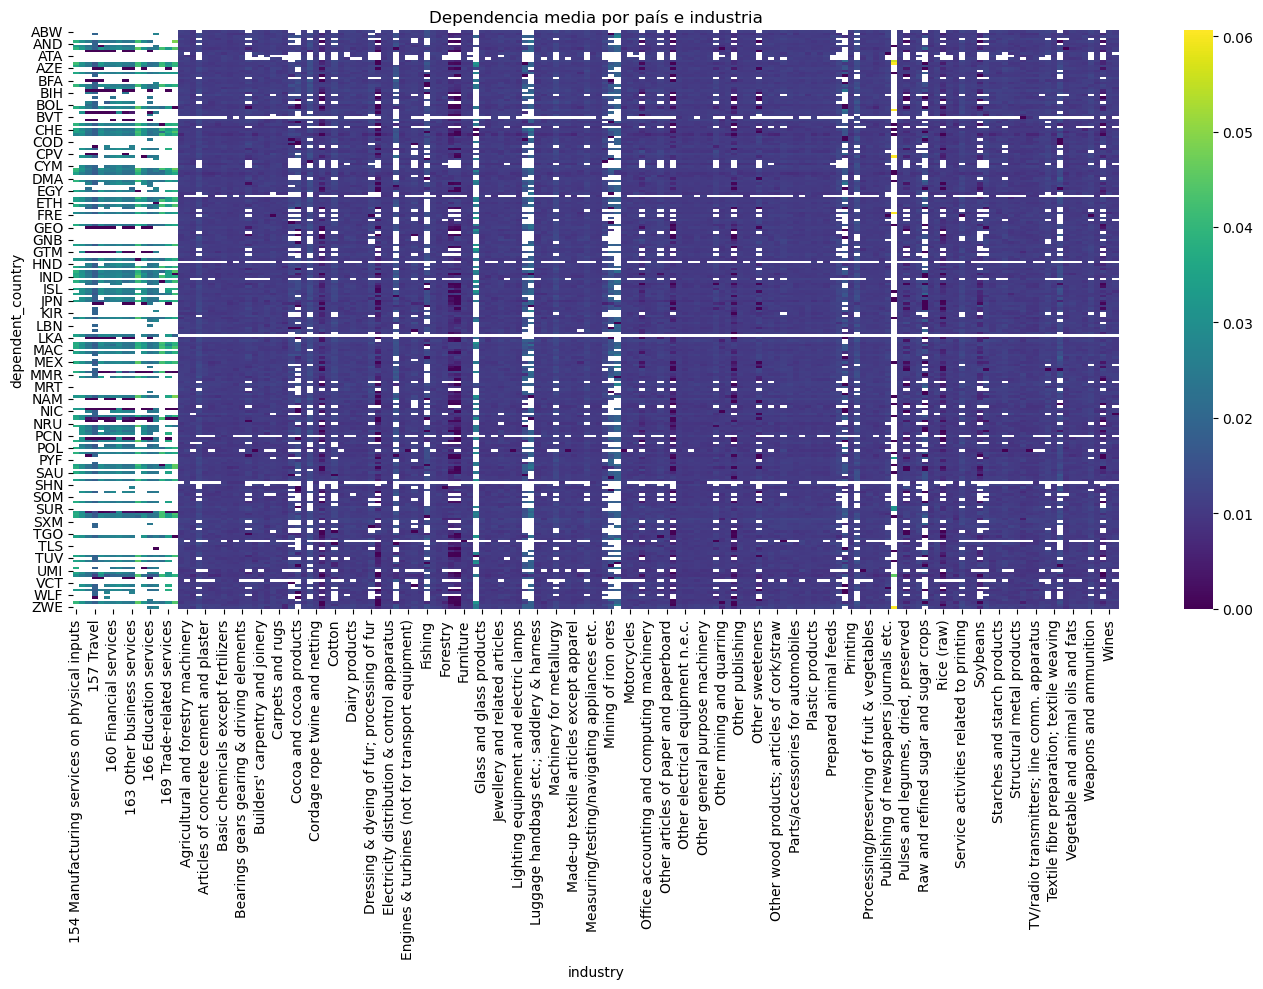

In [38]:
heat_df = (
    deps_clean
    .groupby(["dependent_country", "industry"])["dependency_value"]
    .mean()
    .reset_index()
)

heat_pivot = heat_df.pivot(index="dependent_country", columns="industry", values="dependency_value")

plt.figure(figsize=(14, 10))
sns.heatmap(heat_pivot, cmap="viridis")
plt.title("Dependencia media por país e industria")
plt.tight_layout()
plt.show()


## 🧨 Matriz país-país de criticidad agregada

Creamos una matriz donde cada celda contiene la **criticidad máxima** registrada entre un importador y un exportador, considerando todas las industrias.

Esto permite visualizar:

- pares estructuralmente frágiles
- dependencias geoestratégicas sensibles
- patrones de riesgo bilaterales a nivel sistémico


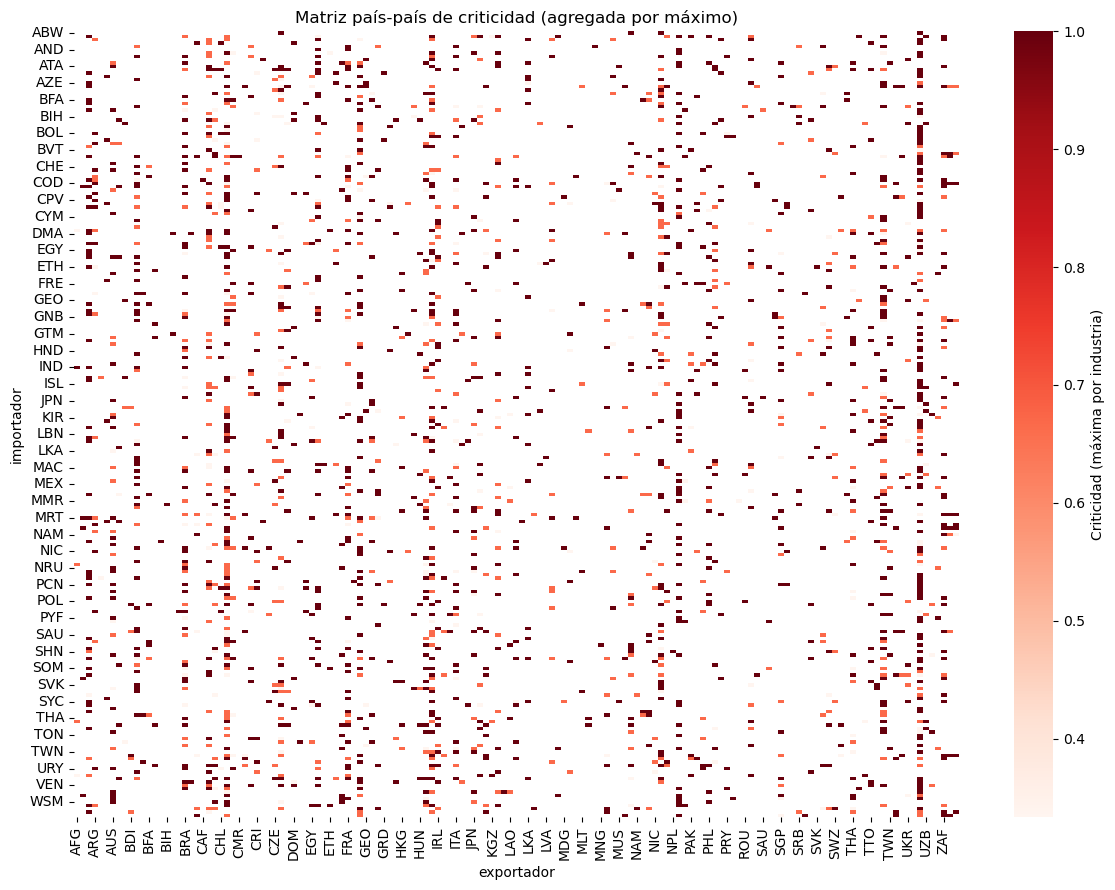

In [39]:
# ================================
#  C2) Matriz país-país de flujos críticos
# ================================

# 1. Agregamos criticidad por par importador-exportador
crit_agg = (
    relaciones_criticas
    .groupby(["importador", "exportador"])["criticidad"]
    .max()           # también podría ser .mean() o .sum()
    .reset_index()
)

# 2. Convertimos a matriz país-país
mat_crit = crit_agg.pivot(
    index="importador",
    columns="exportador",
    values="criticidad"
)

plt.figure(figsize=(12, 9))
sns.heatmap(
    mat_crit,
    cmap="Reds",
    cbar_kws={"label": "Criticidad (máxima por industria)"},
)
plt.title("Matriz país-país de criticidad (agregada por máximo)")
plt.tight_layout()
plt.show()


## 📈 Intermediarios globales: frecuencia vs fuerza

Este scatter plot representa:

- Eje X: frecuencia como intermediario
- Eje Y: fuerza total canalizada
- Tamaño: `global_score`

Permite distinguir distintos tipos de hubs:

- **Hubs de volumen** (alta frecuencia)
- **Hubs de intensidad** (alta fuerza)
- **Hubs sistémicos** (altos en ambas dimensiones)


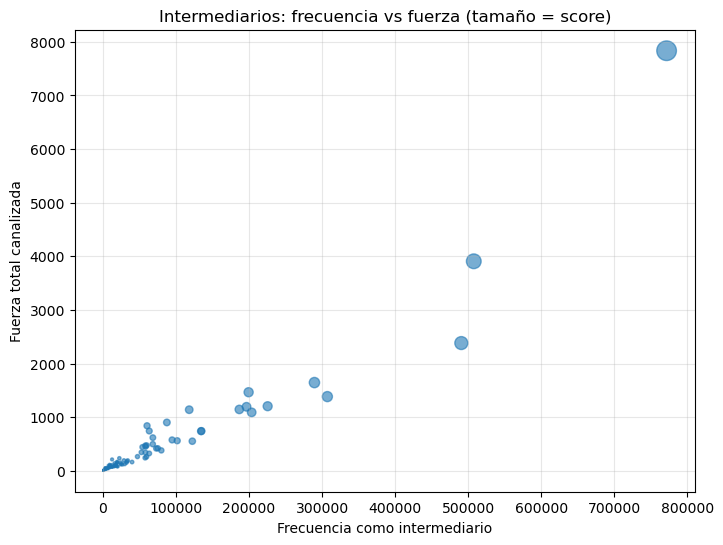

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(
    intermediarios_globales["frequency_total"],
    intermediarios_globales["strength_total"],
    s=intermediarios_globales["global_score"] * 200,
    alpha=0.6
)
plt.xlabel("Frecuencia como intermediario")
plt.ylabel("Fuerza total canalizada")
plt.title("Intermediarios: frecuencia vs fuerza (tamaño = score)")
plt.grid(alpha=0.3)
plt.show()


## ⚖️ Criticidad vs redundancia

Mostramos la relación entre:

- criticidad estructural del vínculo
- número de caminos alternativos disponibles

El gráfico revela:

- pares extremadamente frágiles (alta criticidad, baja redundancia)
- dependencias no críticas pero con pobre diversificación
- puntos de falla potenciales en la red global


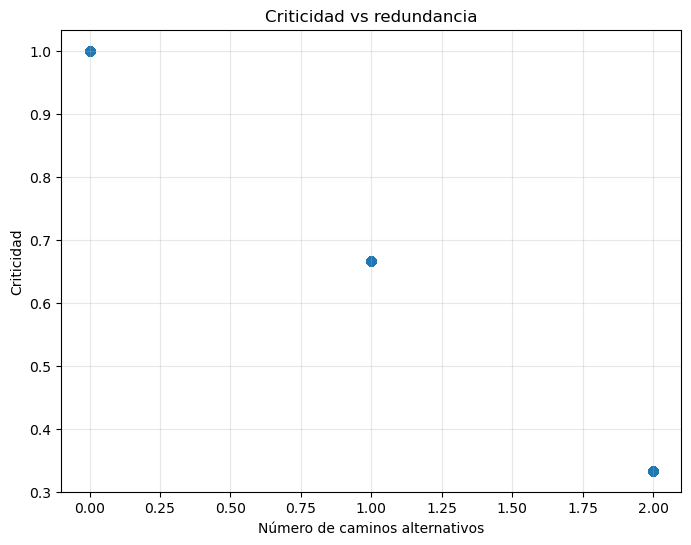

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(
    relaciones_criticas["caminos_alternativos"],
    relaciones_criticas["criticidad"],
    alpha=0.6
)
plt.xlabel("Número de caminos alternativos")
plt.ylabel("Criticidad")
plt.title("Criticidad vs redundancia")
plt.grid(alpha=0.3)
plt.show()


# 📁 Exportación de tablas para el paper

Generamos y guardamos:

- Dependencias completas (`dependencies_full`)
- Dependencias ponderadas por país (`weighted_dependencies`)
- Relaciones críticas (`critical_relations`)
- Roles e indicadores de intermediarios (`intermediary_roles`)
- Resumen enriquecido de los principales hubs (`intermediary_summary`)

Todos los archivos se guardan en:
`paper/ficheros_paper/`

Con formato CSV comprimido para facilitar su integración directa en análisis posteriores y en LaTeX.


In [42]:
# ================================
#  D) Exportación para paper
# ================================

# 1) Dependencias completas
deps_full_path = paper_path / "dependencies_full.csv.gz"
deps_clean.to_csv(deps_full_path, sep=";", index=False, compression="gzip")

# 2) Dependencias ponderadas por país
weighted_dependencies = (
    deps_clean
    .groupby("dependent_country")
    .apply(lambda g: pd.Series({
        "dep_ponderada": np.average(g["dependency_value"], weights=g["trade_value"]),
        "dep_directa_ponderada": np.average(g["direct_dependency"], weights=g["trade_value"]),
        "dep_indirecta_ponderada": np.average(g["indirect_dependency"], weights=g["trade_value"]),
        "trade_total": g["trade_value"].sum()
    }))
    .reset_index()
)

weighted_dep_path = paper_path / "weighted_dependencies.csv.gz"
weighted_dependencies.to_csv(weighted_dep_path, sep=";", index=False, compression="gzip")

# 3) Relaciones críticas
crit_rel_path = paper_path / "critical_relations.csv.gz"
rel_crit_sorted.to_csv(crit_rel_path, sep=";", index=False, compression="gzip")

# 4) Perfiles de intermediarios
interm_roles_path = paper_path / "intermediary_roles.csv.gz"
intermediarios_globales.to_csv(interm_roles_path, sep=";", index=False, compression="gzip")

# 5) Hubs enriquecidos
interm_summary_path = paper_path / "intermediary_summary.csv.gz"
hubs_enriched.to_csv(interm_summary_path, sep=";", index=False, compression="gzip")

print("💾 Exportación completada.")


C:\Users\Usuario\AppData\Local\Temp\ipykernel_50512\1772058714.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


💾 Exportación completada.


# 📊 Preparación de extractos ligeros para el Dashboard

Para el dashboard en Streamlit, generamos versiones reducidas y optimizadas de:

- Perfíl por país (vulnerabilidad, indirect_share, proveedores)
- Top hubs globales
- Relaciones críticas (top 50 pares)
- Heatmap país-industria
- Matriz país-país de criticidad agregada

Todos se almacenan en `dashboard/data/` como `.parquet` para garantizar carga rápida y eficiente en la aplicación interactiva.


In [43]:
dashboard_data_path.mkdir(parents=True, exist_ok=True)

# 1) Vulnerabilidad por país
dashboard_country = country_profiles[[
    "country",
    "vulnerability",
    "indirect_share",
    "num_suppliers_effective",
    "global_rank"
]]
dashboard_country.to_parquet(dashboard_data_path / "country_profiles_lite.parquet", index=False)

# 2) Hubs globales
top_hubs.to_parquet(dashboard_data_path / "global_hubs.parquet", index=False)

# 3) Relaciones críticas (top 50)
top_crit.to_parquet(dashboard_data_path / "critical_relations.parquet", index=False)

# 4) Heatmap en formato largo
heat_df.to_parquet(dashboard_data_path / "country_industry_dependencies.parquet", index=False)

# 5) Matriz país país en formato largo
mat_crit_long = mat_crit.stack().reset_index()
mat_crit_long.columns = ["importer", "exporter", "criticidad"]
mat_crit_long.to_parquet(dashboard_data_path / "country_country_criticidad.parquet", index=False)

print("💾 Extractos para dashboard generados.")


💾 Extractos para dashboard generados.


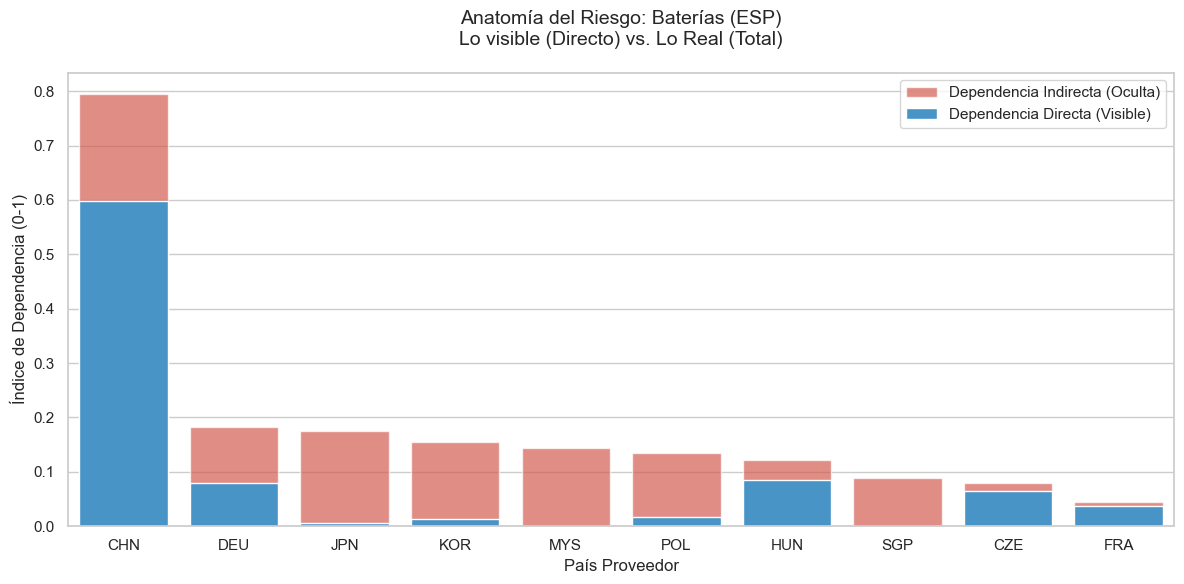

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- CONFIGURACIÓN DEL CASO DE USO ---
PAIS_ANALISIS = "ESP"  # Cambiar por el país que interese al Ministerio
INDUSTRIA_CASO = "Accumulators primary cells and batteries" # Asegúrate que el string coincide exactamente

# Filtramos datos para el caso de uso
caso_df = deps_clean[
    (deps_clean["dependent_country"] == PAIS_ANALISIS) &
    (deps_clean["industry"] == INDUSTRIA_CASO)
].copy()

# Ordenamos por dependencia TOTAL y cogemos los Top 10 proveedores
top_proveedores = caso_df.sort_values("dependency_value", ascending=False).head(10)

# Preparamos datos para gráfico de barras apiladas o comparativo
# Vamos a hacer un gráfico de "Barbell" o barras agrupadas para ver la diferencia
top_proveedores_melted = top_proveedores.melt(
    id_vars=["supplier_country"], 
    value_vars=["direct_dependency", "indirect_dependency"],
    var_name="Tipo Dependencia", 
    value_name="Valor"
)

# --- VISUALIZACIÓN 1: COMPOSICIÓN DEL RIESGO ---
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Crear gráfico de barras apiladas
# Truco: Dibujamos la Total primero y luego la Directa encima para dar efecto de 'lo que no se ve'
sns.barplot(data=top_proveedores, x="supplier_country", y="dependency_value", color="#e74c3c", label="Dependencia Indirecta (Oculta)", alpha=0.7)
sns.barplot(data=top_proveedores, x="supplier_country", y="direct_dependency", color="#3498db", label="Dependencia Directa (Visible)")

plt.title(f"Anatomía del Riesgo: Baterías ({PAIS_ANALISIS})\nLo visible (Directo) vs. Lo Real (Total)", fontsize=14, pad=20)
plt.ylabel("Índice de Dependencia (0-1)")
plt.xlabel("País Proveedor")
plt.legend()
plt.tight_layout()

# Guardar
plt.savefig(paper_path / f"caso_baterias_{PAIS_ANALISIS}_brecha_riesgo.png", dpi=300)
plt.show()

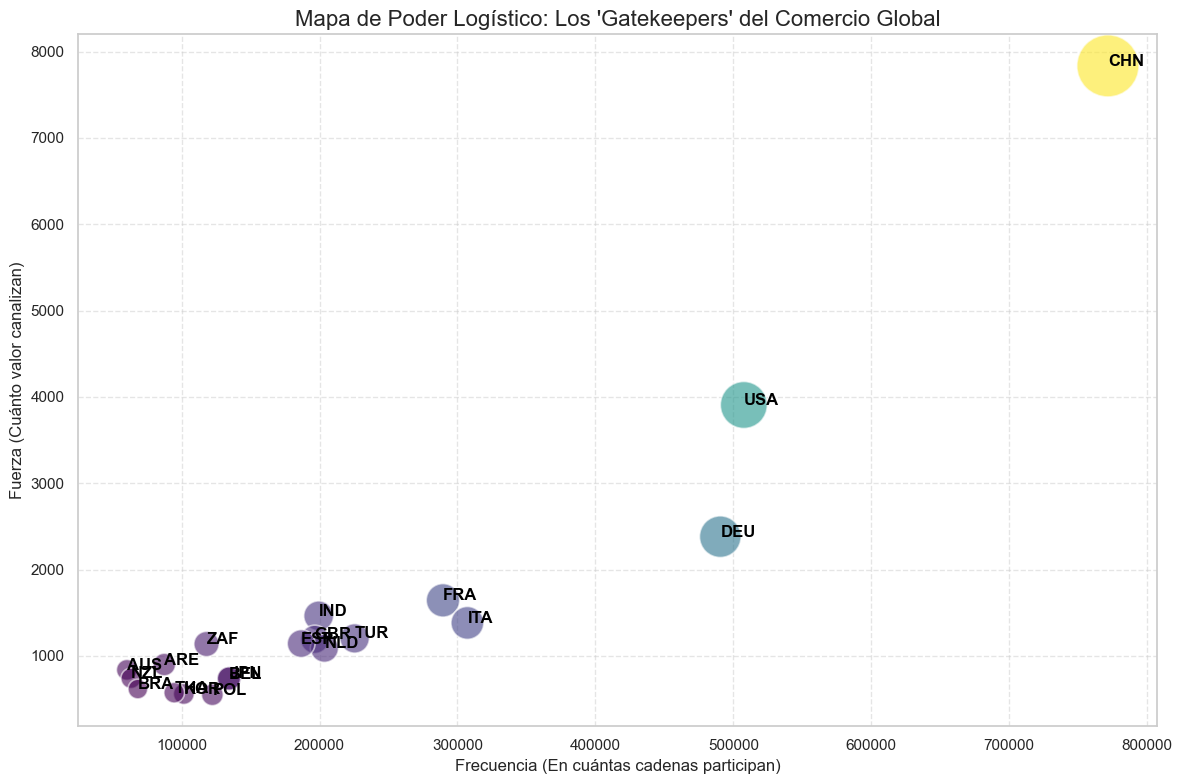

In [45]:
# --- VISUALIZACIÓN 2: TOP HUBS GLOBALES (SCATTER) ---
# Usamos intermediarios_globales cargado previamente

# Cogemos los Top 20
top_hubs_plot = intermediarios_globales.sort_values("global_score", ascending=False).head(20)

plt.figure(figsize=(12, 8))

# Scatter plot: X=Frecuencia, Y=Fuerza, Tamaño=Score
scatter = sns.scatterplot(
    data=top_hubs_plot,
    x="frequency_total",
    y="strength_total",
    size="global_score",
    sizes=(200, 2000), # Círculos grandes
    hue="global_score",
    palette="viridis",
    legend=False,
    alpha=0.6
)

# Añadir etiquetas de texto a los puntos
for i in range(top_hubs_plot.shape[0]):
    plt.text(
        top_hubs_plot.frequency_total.iloc[i]+0.2, 
        top_hubs_plot.strength_total.iloc[i], 
        top_hubs_plot.country.iloc[i], 
        horizontalalignment='left', 
        size='medium', 
        color='black', 
        weight='semibold'
    )

plt.title("Mapa de Poder Logístico: Los 'Gatekeepers' del Comercio Global", fontsize=16)
plt.xlabel("Frecuencia (En cuántas cadenas participan)")
plt.ylabel("Fuerza (Cuánto valor canalizan)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

plt.savefig(paper_path / "mapa_hubs_globales.png", dpi=300)
plt.show()

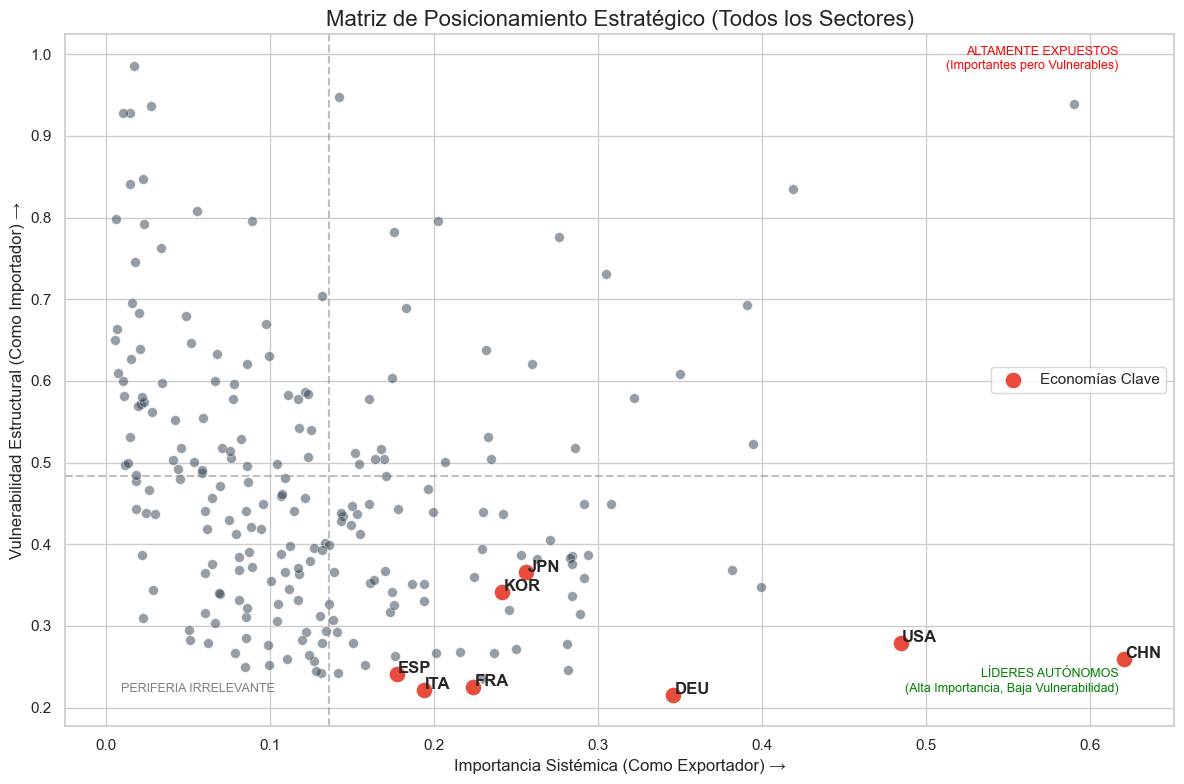

In [46]:
# --- VISUALIZACIÓN 3: MATRIZ IMPORTANCIA VS VULNERABILIDAD ---
# Usamos country_profiles

plt.figure(figsize=(12, 8))

# Definimos cuadrantes
plt.axhline(y=country_profiles["vulnerability"].mean(), color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=country_profiles["importance"].mean(), color='gray', linestyle='--', alpha=0.5)

sns.scatterplot(
    data=country_profiles,
    x="importance",
    y="vulnerability",
    color="#2c3e50",
    alpha=0.5,
    s=50
)

# Destacamos países clave
paises_destacar = ["USA", "CHN", "DEU", "ESP", "FRA", "ITA", "JPN", "KOR"]
df_destacar = country_profiles[country_profiles["country"].isin(paises_destacar)]

sns.scatterplot(
    data=df_destacar,
    x="importance",
    y="vulnerability",
    color="#e74c3c",
    s=150,
    label="Economías Clave"
)

# Etiquetas
for i, row in df_destacar.iterrows():
    plt.text(row["importance"]+0.001, row["vulnerability"]+0.001, row["country"], weight='bold')

plt.title("Matriz de Posicionamiento Estratégico (Todos los Sectores)", fontsize=16)
plt.xlabel("Importancia Sistémica (Como Exportador) →")
plt.ylabel("Vulnerabilidad Estructural (Como Importador) →")

# Anotaciones de cuadrantes
plt.text(0.95, 0.95, 'ALTAMENTE EXPUESTOS\n(Importantes pero Vulnerables)', transform=plt.gca().transAxes, ha='right', fontsize=9, color='red')
plt.text(0.05, 0.05, 'PERIFERIA IRRELEVANTE', transform=plt.gca().transAxes, ha='left', fontsize=9, color='gray')
plt.text(0.95, 0.05, 'LÍDERES AUTÓNOMOS\n(Alta Importancia, Baja Vulnerabilidad)', transform=plt.gca().transAxes, ha='right', fontsize=9, color='green')

plt.tight_layout()
plt.savefig(paper_path / "matriz_posicionamiento_estrategico.png", dpi=300)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_50512\590884509.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vuln_por_ind = df_pais.groupby("industry").apply(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_50512\590884509.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=vuln_por_ind.values, y=vuln_por_ind.index, palette="Reds_r")


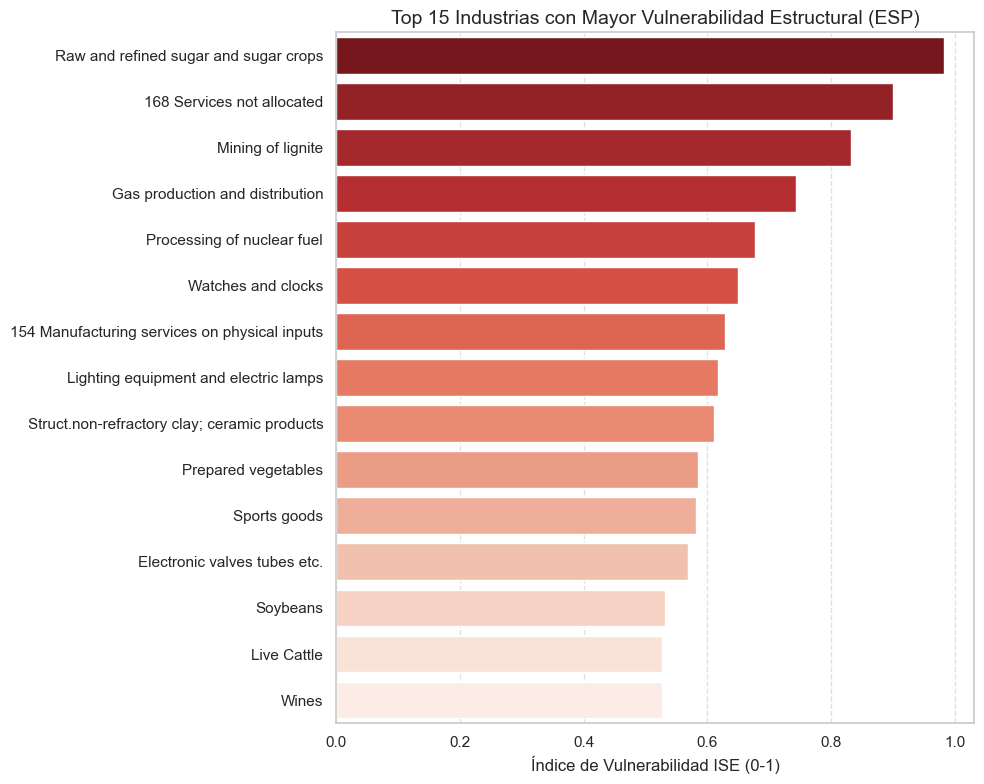

C:\Users\Usuario\AppData\Local\Temp\ipykernel_50512\590884509.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_brecha = df_pais.groupby("industry").apply(


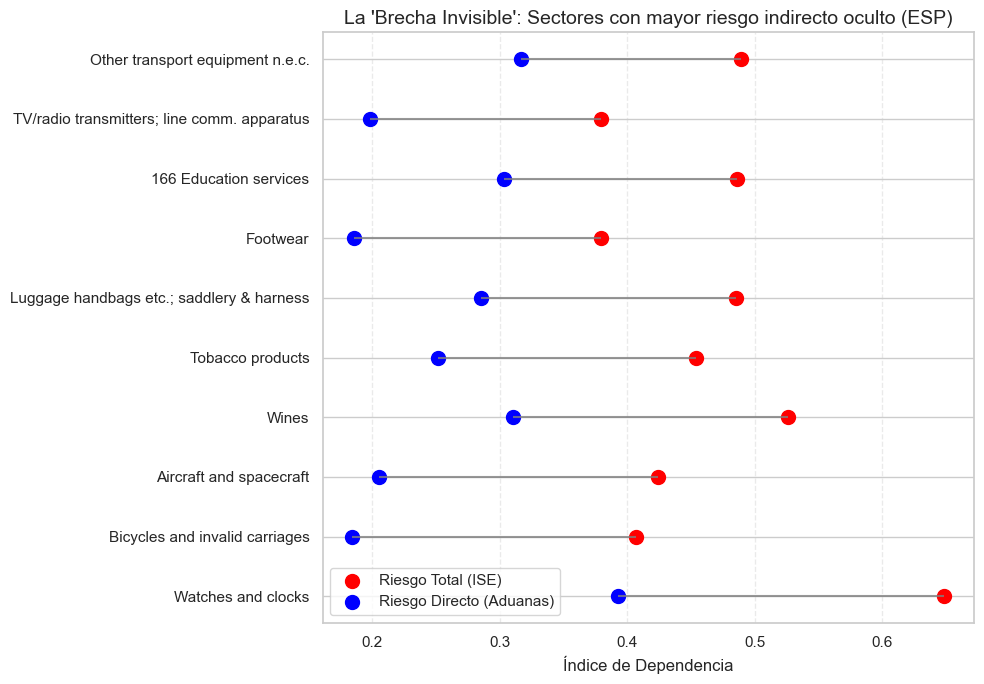


--- TABLA 3.1: ALERTA DE CONCENTRACIÓN (ESP) ---
| industry                                             |   Proveedores_Efectivos |
|:-----------------------------------------------------|------------------------:|
| Raw and refined sugar and sugar crops                |                    1.03 |
| 168 Services not allocated                           |                    1.11 |
| Mining of lignite                                    |                    1.23 |
| Gas production and distribution                      |                    1.37 |
| Processing of nuclear fuel                           |                    1.58 |
| 154 Manufacturing services on physical inputs        |                    1.8  |
| Soybeans                                             |                    1.91 |
| Electricity production, collection, and distribution |                    1.93 |
| Struct.non-refractory clay; ceramic products         |                    1.97 |
| Electronic valves tubes etc.       

C:\Users\Usuario\AppData\Local\Temp\ipykernel_50512\590884509.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conc_df = df_pais.groupby("industry").apply(calc_eff_suppliers).rename("Proveedores_Efectivos").sort_values()


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# CONFIGURACIÓN
PAIS_ANALISIS = "ESP"  # Cambia esto por el ISO3 del país cliente
top_n_industrias = 15

# Filtrar datos solo para el país de análisis como importador
df_pais = deps_clean[deps_clean["dependent_country"] == PAIS_ANALISIS].copy()

# --- FIGURA 3.1: RANKING DE VULNERABILIDAD POR INDUSTRIA ---
# Agrupamos por industria y calculamos la media ponderada de la dependencia total
vuln_por_ind = df_pais.groupby("industry").apply(
    lambda x: np.average(x["dependency_value"], weights=x["trade_value"])
).sort_values(ascending=False).head(top_n_industrias)

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=vuln_por_ind.values, y=vuln_por_ind.index, palette="Reds_r")
plt.title(f"Top {top_n_industrias} Industrias con Mayor Vulnerabilidad Estructural ({PAIS_ANALISIS})", fontsize=14)
plt.xlabel("Índice de Vulnerabilidad ISE (0-1)")
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(paper_path / f"fig_3_1_ranking_vulnerabilidad_{PAIS_ANALISIS}.png", dpi=300)
plt.show()

# --- FIGURA 3.2: BRECHA DIRECTA VS INDIRECTA (SECTORES ESTRATÉGICOS) ---
# Seleccionamos sectores con mayor diferencia entre Total y Directa
df_brecha = df_pais.groupby("industry").apply(
    lambda x: pd.Series({
        'Total': np.average(x["dependency_value"], weights=x["trade_value"]),
        'Directa': np.average(x["direct_dependency"], weights=x["trade_value"])
    })
)
df_brecha['Brecha'] = df_brecha['Total'] - df_brecha['Directa']
top_brecha = df_brecha.sort_values('Brecha', ascending=False).head(10)

# Preparamos datos para gráfico tipo Dumbbell
plt.figure(figsize=(10, 7))
plt.hlines(y=top_brecha.index, xmin=top_brecha['Directa'], xmax=top_brecha['Total'], color='grey', alpha=0.8)
plt.scatter(top_brecha['Total'], top_brecha.index, color='red', alpha=1, label='Riesgo Total (ISE)', s=100)
plt.scatter(top_brecha['Directa'], top_brecha.index, color='blue', alpha=1, label='Riesgo Directo (Aduanas)', s=100)
plt.legend()
plt.title(f"La 'Brecha Invisible': Sectores con mayor riesgo indirecto oculto ({PAIS_ANALISIS})", fontsize=14)
plt.xlabel("Índice de Dependencia")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(paper_path / f"fig_3_2_brecha_riesgo_{PAIS_ANALISIS}.png", dpi=300)
plt.show()

# --- TABLA 3.1: CONCENTRACIÓN (HHI Inverso) ---
# Usamos la lógica de HHI que ya tenías en el fichero 2, pero focalizado
def calc_eff_suppliers(g):
    if g['trade_value'].sum() == 0: return 0
    shares = g['trade_value'] / g['trade_value'].sum()
    hhi = (shares ** 2).sum()
    return 1 / hhi if hhi > 0 else 0

conc_df = df_pais.groupby("industry").apply(calc_eff_suppliers).rename("Proveedores_Efectivos").sort_values()
# Filtramos las 10 industrias más concentradas (menor número de proveedores efectivos)
tabla_concentracion = conc_df.head(10).reset_index()
tabla_concentracion["Proveedores_Efectivos"] = tabla_concentracion["Proveedores_Efectivos"].round(2)

print(f"\n--- TABLA 3.1: ALERTA DE CONCENTRACIÓN ({PAIS_ANALISIS}) ---")
print(tabla_concentracion.to_markdown(index=False))

# Guardar CSV para insertar en el informe
tabla_concentracion.to_csv(paper_path / f"tabla_3_1_concentracion_{PAIS_ANALISIS}.csv", index=False, sep=";")

✅ Figura 4.1 guardada en: c:\Users\Usuario\Documents\Github\Seguridad Economica\paper\ficheros_paper\fig_4_1_hubs_globales.png


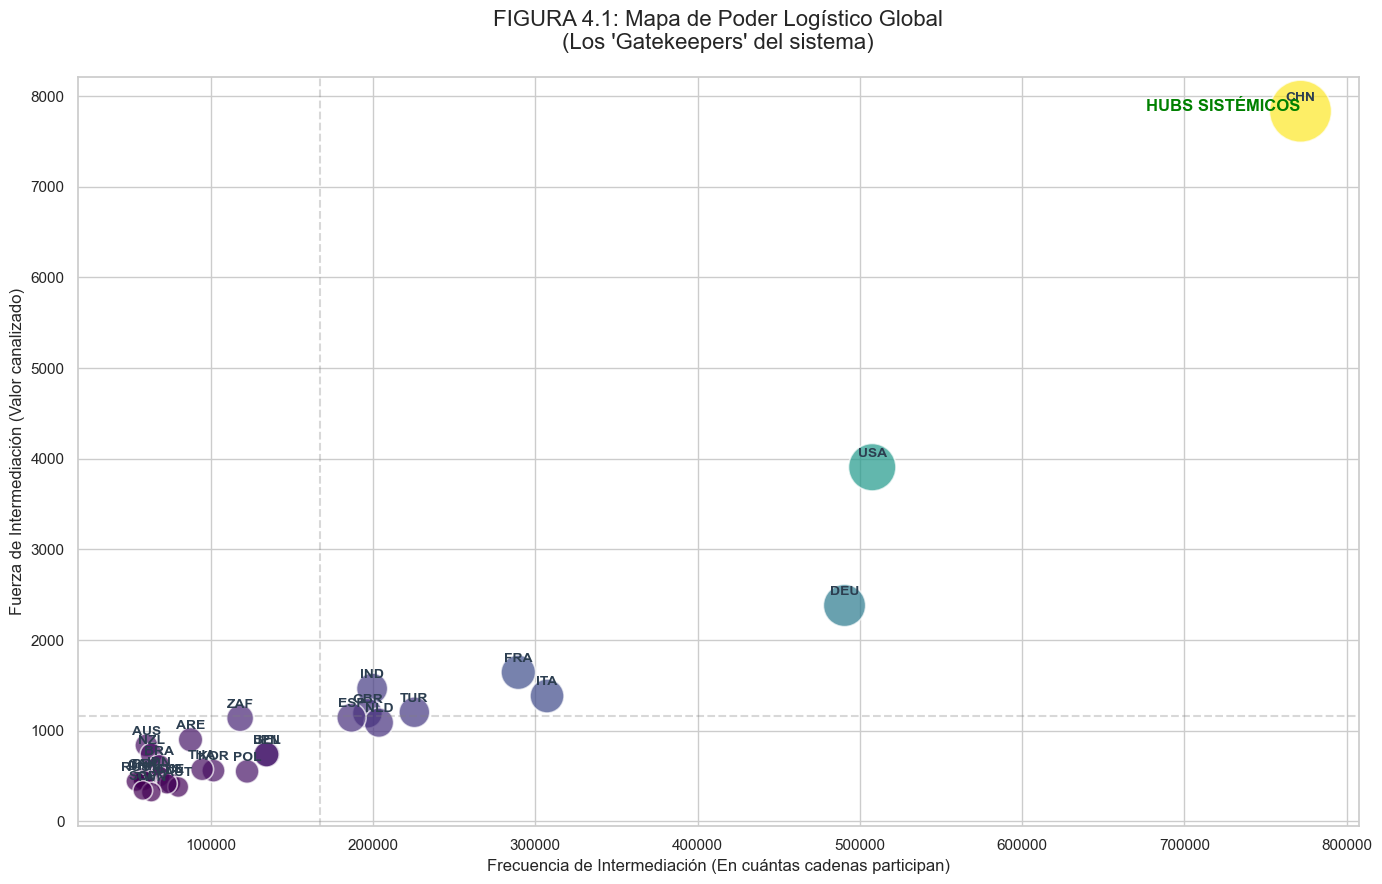

✅ Figura 4.2 guardada en: c:\Users\Usuario\Documents\Github\Seguridad Economica\paper\ficheros_paper\fig_4_2_matriz_criticidad_ESP.png


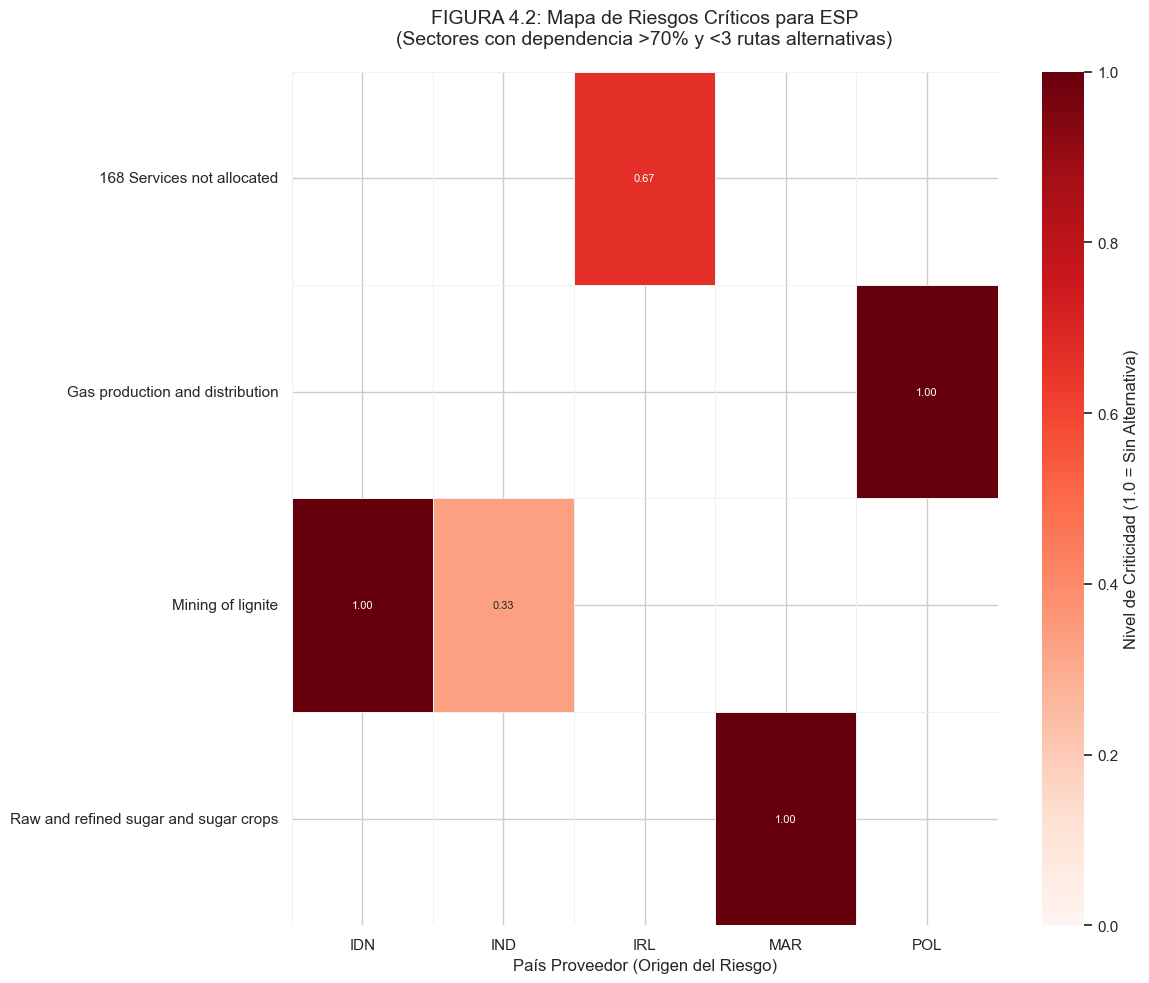

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- CONFIGURACIÓN GENERAL ---
sns.set_theme(style="whitegrid")
PAIS_ANALISIS = "ESP"  # Cambia esto si analizas otro país
# Ajustar rutas si no están definidas
if 'paper_path' not in locals():
    from pathlib import Path
    paper_path = Path.cwd() # O define tu ruta de salida

# ==============================================================================
# FIGURA 4.1: MAPA DE PODER LOGÍSTICO (HUBS GLOBALES)
# Scatter Plot: Frecuencia vs. Fuerza, ponderado por Score
# ==============================================================================

# 1. Preparamos los datos: Top 30 Hubs para no saturar el gráfico
top_hubs_plot = intermediarios_globales.sort_values("global_score", ascending=False).head(30).copy()

plt.figure(figsize=(14, 9))

# 2. Crear el Scatter Plot
# Usamos 'hue' para el color y 'size' para el tamaño de la burbuja
scatter = sns.scatterplot(
    data=top_hubs_plot,
    x="frequency_total",
    y="strength_total",
    size="global_score",
    sizes=(200, 2000),     # Tamaño mín y máx de las burbujas
    hue="global_score",
    palette="viridis",     # Escala de colores profesional
    alpha=0.7,
    legend=False           # Ocultamos leyenda para limpiar
)

# 3. Etiquetado Inteligente
# Solo etiquetamos los países para evitar solapamientos masivos
for i, row in top_hubs_plot.iterrows():
    # Offset para que el texto no caiga justo encima del punto
    plt.text(
        row['frequency_total'], 
        row['strength_total'] + (top_hubs_plot['strength_total'].max() * 0.015), 
        row['country'], 
        horizontalalignment='center',
        fontsize=10, 
        weight='bold',
        color='#2c3e50'
    )

# 4. Decoración
plt.title("FIGURA 4.1: Mapa de Poder Logístico Global\n(Los 'Gatekeepers' del sistema)", fontsize=16, pad=20)
plt.xlabel("Frecuencia de Intermediación (En cuántas cadenas participan)", fontsize=12)
plt.ylabel("Fuerza de Intermediación (Valor canalizado)", fontsize=12)

# Añadir cuadrantes teóricos (líneas medias)
plt.axhline(y=top_hubs_plot['strength_total'].mean(), color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=top_hubs_plot['frequency_total'].mean(), color='gray', linestyle='--', alpha=0.3)
plt.text(top_hubs_plot['frequency_total'].max(), top_hubs_plot['strength_total'].max(), "HUBS SISTÉMICOS", color='green', ha='right', weight='bold')

plt.tight_layout()
save_path_41 = paper_path / "fig_4_1_hubs_globales.png"
plt.savefig(save_path_41, dpi=300)
print(f"✅ Figura 4.1 guardada en: {save_path_41}")
plt.show()


# ==============================================================================
# FIGURA 4.2: MATRIZ DE CRITICIDAD (PAÍS-PAÍS) PARA EL IMPORTADOR
# Heatmap: Industrias vs. Proveedores Problemáticos
# ==============================================================================

# 1. Filtrar relaciones críticas donde el importador es nuestro PAIS_ANALISIS
df_crit_pais = relaciones_criticas[relaciones_criticas['importador'] == PAIS_ANALISIS].copy()

if not df_crit_pais.empty:
    # 2. Selección de Datos Relevantes
    # Si hay muchísimos proveedores, el mapa es ilegible.
    # Seleccionamos los "Top 15 Proveedores Problemáticos" (los que aparecen en más industrias críticas)
    top_proveedores_criticos = df_crit_pais['exportador'].value_counts().head(15).index
    
    df_heatmap = df_crit_pais[df_crit_pais['exportador'].isin(top_proveedores_criticos)]
    
    # Seleccionamos también las Top 20 Industrias con mayor criticidad media
    top_industrias_criticas = df_heatmap.groupby('industry')['criticidad'].max().sort_values(ascending=False).head(20).index
    df_heatmap = df_heatmap[df_heatmap['industry'].isin(top_industrias_criticas)]

    # 3. Pivotar para crear matriz (Filas: Industria, Columnas: Proveedor, Valor: Criticidad)
    matriz_crit = df_heatmap.pivot_table(
        index='industry', 
        columns='exportador', 
        values='criticidad', 
        aggfunc='max' # Si hay duplicados, coge el peor caso
    )

    # 4. Crear el Heatmap
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        matriz_crit, 
        cmap="Reds",        # Rojo = Peligro
        linewidths=.5, 
        linecolor='#f0f0f0',
        vmin=0, vmax=1,     # Escala de 0 a 1
        cbar_kws={'label': 'Nivel de Criticidad (1.0 = Sin Alternativa)'},
        annot=True,         # Poner el número dentro de la celda
        fmt=".2f",
        annot_kws={"size": 8}
    )

    plt.title(f"FIGURA 4.2: Mapa de Riesgos Críticos para {PAIS_ANALISIS}\n(Sectores con dependencia >70% y <3 rutas alternativas)", fontsize=14, pad=20)
    plt.xlabel("País Proveedor (Origen del Riesgo)")
    plt.ylabel("")
    
    plt.tight_layout()
    save_path_42 = paper_path / f"fig_4_2_matriz_criticidad_{PAIS_ANALISIS}.png"
    plt.savefig(save_path_42, dpi=300)
    print(f"✅ Figura 4.2 guardada en: {save_path_42}")
    plt.show()

else:
    print(f"⚠️ ¡Buenas noticias! No se encontraron relaciones críticas extremas para {PAIS_ANALISIS} con los umbrales actuales (Dep>0.7, Caminos<3).")
    print("Considera bajar los umbrales en el paso anterior si quieres forzar el gráfico.")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_50512\746406556.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rutas, x="fuerza_agregada", y="ruta_str", palette="viridis")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_50512\746406556.py:53: UserWarning: Glyph 10132 (\N{HEAVY WIDE-HEADED RIGHTWARDS ARROW}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_50512\746406556.py:54: UserWarning: Glyph 10132 (\N{HEAVY WIDE-HEADED RIGHTWARDS ARROW}) missing from font(s) Arial.
  plt.savefig(paper_path / "fig_5_2_rutas_baterias.png", dpi=300)
c:\Users\Usuario\anaconda3\envs\dependencias\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10132 (\N{HEAVY WIDE-HEADED RIGHTWARDS ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


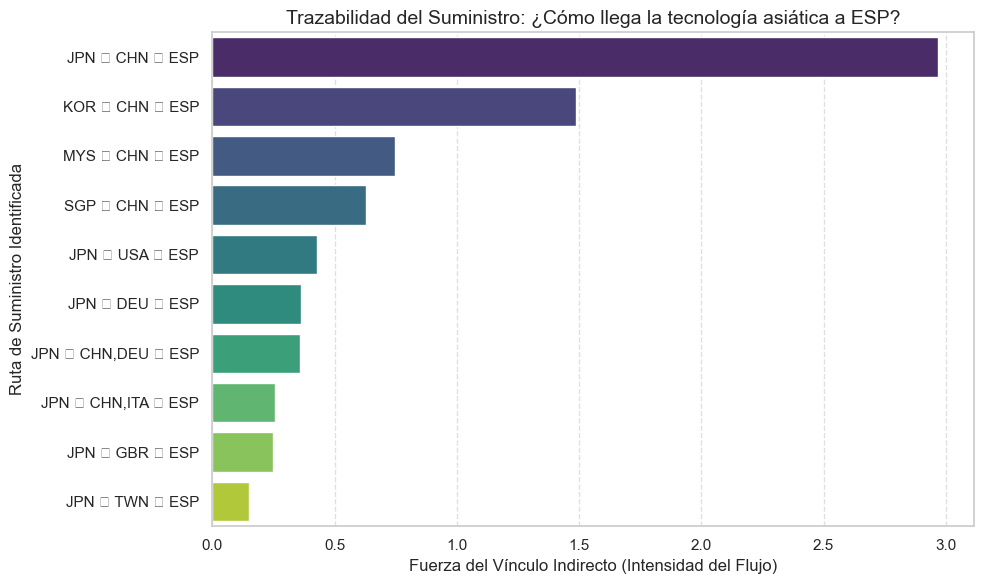

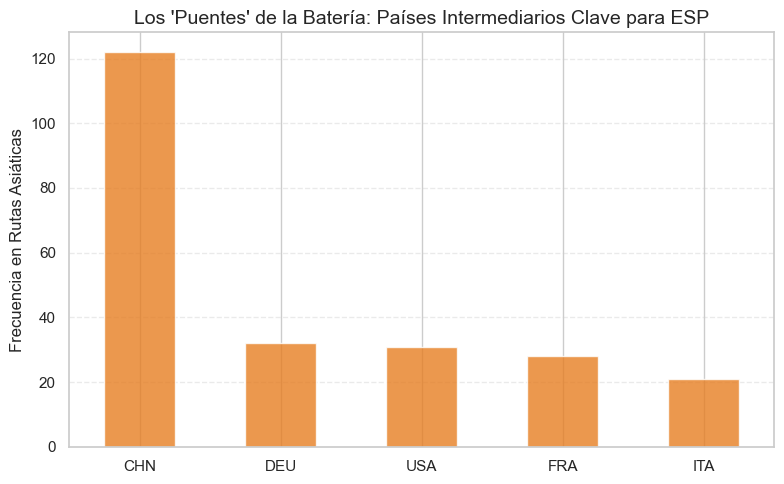

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# CONFIGURACIÓN
PAIS_ANALISIS = "ESP"
INDUSTRIA_CASO = "Accumulators primary cells and batteries"

# --- PREPARACIÓN DE DATOS PARA FIGURA 5.2 (RUTAS) ---
# Necesitamos saber: ¿Cómo llega el riesgo de los países "invisibles" (KOR, JPN, MYS) a España?
# Usamos 'caminos_significativos' que cargamos en el script anterior
# Filtramos por industria, importador ESP, y exportadores de interés (los asiáticos ocultos)

exportadores_ocultos = ["KOR", "JPN", "MYS", "SGP"]

rutas_caso = caminos_significativos[
    (caminos_significativos['importador'] == PAIS_ANALISIS) &
    (caminos_significativos['exportador'].isin(exportadores_ocultos))
    # Nota: Si caminos_significativos no tiene columna 'industry', 
    # usaremos 'all_results' o asumiremos que el parquet global agrega fuerza.
    # Si tu parquet 'caminos_significativos' no tiene industria, este filtro es genérico.
    # Asumamos que queremos ver las rutas más fuertes globalmente para estos pares.
].copy()

# Si el dataframe tiene 'industry', filtramos. Si no (porque es agregado), usamos el general.
# En tu estructura anterior, 'caminos_significativos.parquet' tenía 'num_industrias' pero no 'industry' explícita por fila si está agregado.
# PERO, en 'all_results' (pickle) sí lo tienes detallado. 
# PARA SIMPLIFICAR: Vamos a usar la lógica de "Intermediarios más frecuentes" para estos pares.

# Desglosamos la lista de intermediarios (que viene como string o lista)
# Asumiendo que viene como string "['DEU']" o lista real.
def limpiar_intermediarios(val):
    if isinstance(val, str):
        return val.replace("[","").replace("]","").replace("'","")
    return ",".join(val)

rutas_caso['ruta_str'] = routes_labels = rutas_caso.apply(
    lambda x: f"{x['exportador']} ➔ {limpiar_intermediarios(x['intermediarios'])} ➔ {x['importador']}", axis=1
)

# Cogemos las 10 rutas con mayor fuerza agregada
top_rutas = rutas_caso.sort_values("fuerza_agregada", ascending=False).head(10)


# --- FIGURA 5.2: TOP RUTAS INDIRECTAS (CÓMO LLEGA EL RIESGO) ---
plt.figure(figsize=(10, 6))
sns.barplot(data=top_rutas, x="fuerza_agregada", y="ruta_str", palette="viridis")

plt.title(f"Trazabilidad del Suministro: ¿Cómo llega la tecnología asiática a {PAIS_ANALISIS}?", fontsize=14)
plt.xlabel("Fuerza del Vínculo Indirecto (Intensidad del Flujo)")
plt.ylabel("Ruta de Suministro Identificada")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(paper_path / "fig_5_2_rutas_baterias.png", dpi=300)
plt.show()


# --- FIGURA 5.3: LOS "ASSEMBLERS" (INTERMEDIARIOS CLAVE EN ESTOS FLUJOS) ---
# ¿Quién aparece más veces en medio de KOR/JPN/MYS -> ESP?
from collections import Counter
all_interms = []
for sublist in rutas_caso['intermediarios']:
    if isinstance(sublist, str):
        # Si es string de pandas "['DEU', 'FRA']"
        import ast
        try: val = ast.literal_eval(sublist)
        except: val = [sublist]
    else:
        val = sublist
    all_interms.extend(val)

conteo_interms = pd.Series(Counter(all_interms)).sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 5))
conteo_interms.plot(kind='bar', color='#e67e22', alpha=0.8)
plt.title(f"Los 'Puentes' de la Batería: Países Intermediarios Clave para {PAIS_ANALISIS}", fontsize=14)
plt.ylabel("Frecuencia en Rutas Asiáticas")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(paper_path / "fig_5_3_puentes_baterias.png", dpi=300)
plt.show()